In [1]:
from Almanac.Data import get_weather_data
from Almanac.Data import binarize
from Almanac.Data import get_frost_dates
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

%matplotlib inline

In [64]:
df = get_weather_data("Chicago, IL, 60601, US", "1980-01-01", "2021-12-31")
df = binarize(df, "tmin")

In [65]:
df.head()

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,tmin_bin
time,,,,,,,,,,,
1980-01-01,-2.1,-4.4,7.2,0.0,0.0,262.0,11.7,20.5,1015.7,NaN,1.0
1980-01-02,-0.6,-4.4,-1.1,0.0,0.0,322.0,13.7,31.3,1018.5,NaN,1.0
1980-01-03,-1.8,-2.8,1.1,0.0,0.0,24.0,17.3,33.5,1024.9,NaN,1.0
1980-01-04,-2.6,-3.3,-0.6,0.0,0.0,32.0,15.9,25.9,1021.8,NaN,1.0
1980-01-05,-3.1,-4.4,-1.7,0.5,0.0,322.0,16.4,24.1,1021.4,NaN,1.0


In [66]:
first, last = get_frost_dates(df)

In [67]:
f = pd.Series(first).dropna()
l = pd.Series(last).dropna()

In [68]:
tt = pd.DataFrame({"first": f, "last": l})
tt["year"] = tt["first"].apply(lambda x: x.strftime("%Y"))
tt["last_date"] = tt["last"].apply(lambda x: x.strftime("%m-%d"))
tt["first_date"] = tt["first"].apply(lambda x: x.strftime("%m-%d"))

In [69]:
tt.head()

,first,last,year,last_date,first_date
0,1980-10-05,1980-05-15,1980,05-15,10-05
1,1981-10-03,1981-05-12,1981,05-12,10-03
2,1982-10-22,1982-04-28,1982,04-28,10-22
3,1983-11-05,1983-05-09,1983,05-09,11-05
4,1984-10-24,1984-04-07,1984,04-07,10-24


In [70]:
i = (
    pd.Series(first + last)
    .dropna()
    .apply(lambda x: x.strftime("%m-%d"))
    .apply(lambda x: datetime.strptime(x, "%m-%d"))
)
j = i.value_counts()

dates_df = pd.DataFrame(
    index=pd.date_range(start="1900-01-01", end="1900-12-31"),
    columns=["first", "last"],
)

for d in j.loc[
    tt["last_date"].apply(lambda x: datetime.strptime(x, "%m-%d")).unique()
].index:
    dates_df.loc[d]["last"] = j.loc[d]

for d in j.loc[
    tt["first_date"].apply(lambda x: datetime.strptime(x, "%m-%d")).unique()
].index:
    dates_df.loc[d]["first"] = j.loc[d]

dates_df.fillna(0, inplace=True)

In [71]:
dates_df.head()

,first,last
1900-01-01,0,0
1900-01-02,0,0
1900-01-03,0,0
1900-01-04,0,0
1900-01-05,0,0


In [72]:
df.head()

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,tmin_bin
time,,,,,,,,,,,
1980-01-01,-2.1,-4.4,7.2,0.0,0.0,262.0,11.7,20.5,1015.7,NaN,1.0
1980-01-02,-0.6,-4.4,-1.1,0.0,0.0,322.0,13.7,31.3,1018.5,NaN,1.0
1980-01-03,-1.8,-2.8,1.1,0.0,0.0,24.0,17.3,33.5,1024.9,NaN,1.0
1980-01-04,-2.6,-3.3,-0.6,0.0,0.0,32.0,15.9,25.9,1021.8,NaN,1.0
1980-01-05,-3.1,-4.4,-1.7,0.5,0.0,322.0,16.4,24.1,1021.4,NaN,1.0


In [73]:
from statsmodels.tsa.ar_model import AutoReg as AR
from statsmodels.tsa import ar_model

In [96]:
# search = ar_model.ar_select_order(df['tmin'],maxlag=20,ic='bic',glob=True)
# search.ar_lags
lags = [1, 2, 3, 5, 8, 10, 12, 17, 19]

In [103]:
model = AR(df["tmin"].diff().dropna(), lags=1)
ARfit = model.fit()
# print(f'Lag: {ARfit.k_ar}')
print(f"Coefficients:\n{ARfit.params}")

Coefficients:
const      0.000364
tmin.L1   -0.015993
dtype: float64


In [99]:
df_test = get_weather_data(
    "Chicago, IL, 60601, US", "2022-01-01", "2022-12-31"
)

<Axes: xlabel='time'>

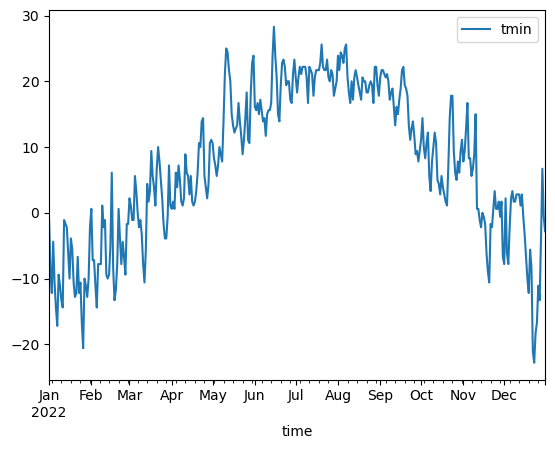

In [100]:
df_test.plot(y="tmin")

In [89]:
start = len(df["tmin"])
end = len(df["tmin"]) + len(df_test["tmin"]) - 1

In [90]:
ARfit.params

const      0.366197
tmin.L1    0.943136
dtype: float64

In [104]:
predictions = ARfit.predict(
    start="2022-01-01", end="2022-12-31", dynamic=False
)

<Axes: xlabel='time'>

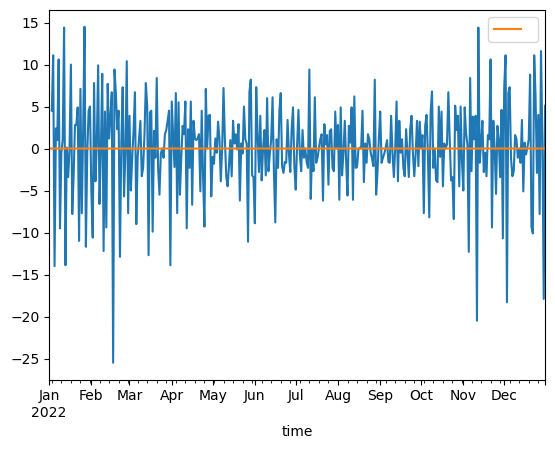

In [110]:
df_test["tmin"].diff().diff().plot()
predictions.plot(legend=True)

In [85]:
df.head()

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,tmin_bin
time,,,,,,,,,,,
1980-01-01,-2.1,-4.4,7.2,0.0,0.0,262.0,11.7,20.5,1015.7,NaN,1.0
1980-01-02,-0.6,-4.4,-1.1,0.0,0.0,322.0,13.7,31.3,1018.5,NaN,1.0
1980-01-03,-1.8,-2.8,1.1,0.0,0.0,24.0,17.3,33.5,1024.9,NaN,1.0
1980-01-04,-2.6,-3.3,-0.6,0.0,0.0,32.0,15.9,25.9,1021.8,NaN,1.0
1980-01-05,-3.1,-4.4,-1.7,0.5,0.0,322.0,16.4,24.1,1021.4,NaN,1.0


<Axes: xlabel='time'>

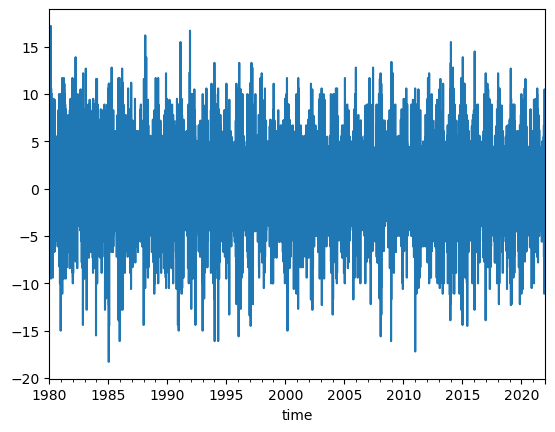

In [95]:
df["tmin"].diff().plot()

In [111]:
from statsmodels.graphics.tsaplots import month_plot, quarter_plot

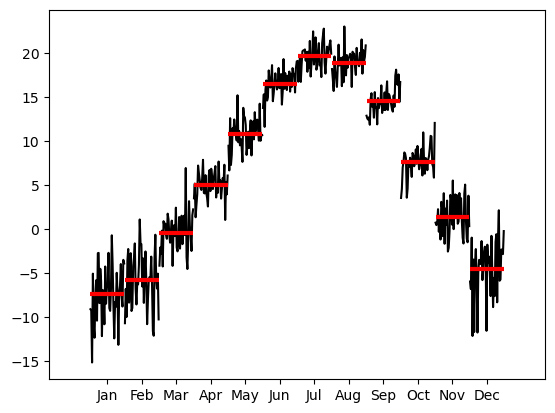

In [115]:
month_plot(df["tmin"].resample("M").mean());

In [116]:
from pandas.plotting import lag_plot

Text(0.5, 1.0, 'Chicago Data 1980-2021 lag_plot')

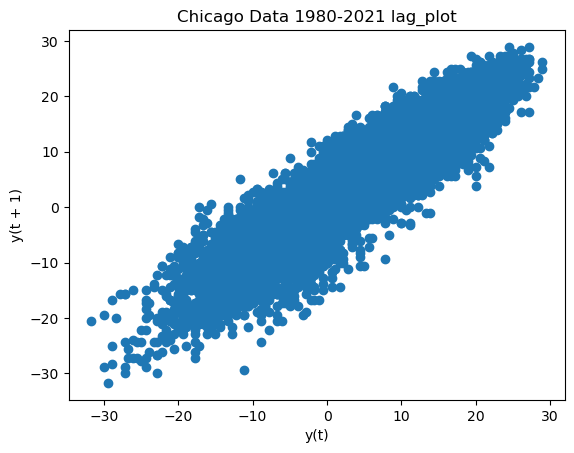

In [119]:
lag_plot(df["tmin"])
plt.title("Chicago Data 1980-2021 lag_plot")

In [120]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

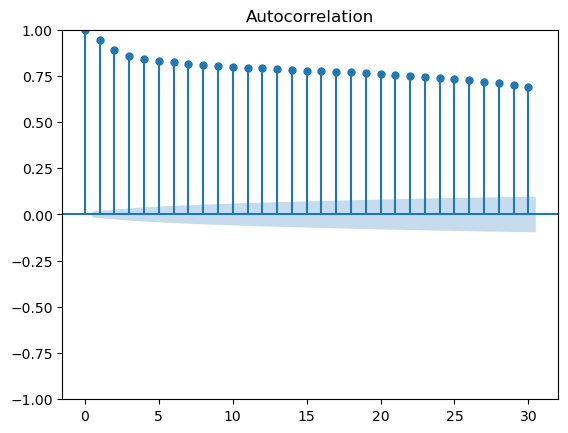

In [126]:
plot_acf(df["tmin"], lags=30);

In [129]:
from pmdarima import auto_arima

In [159]:
fitar = auto_arima(
    df["tmin"],
    start_p=2,
    start_q=2,
    max_p=8,
    max_q=8,
    seasonal=True,
    trace=True,
    m=7,
    information_criterion="bic",
)

Performing stepwise search to minimize bic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : BIC=80931.645, Time=30.77 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : BIC=116113.225, Time=0.24 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : BIC=82334.171, Time=5.53 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : BIC=96266.483, Time=5.31 sec
 ARIMA(0,0,0)(0,0,0)[7]             : BIC=120881.545, Time=0.14 sec
 ARIMA(2,0,2)(0,0,1)[7] intercept   : BIC=80920.683, Time=15.03 sec
 ARIMA(2,0,2)(0,0,0)[7] intercept   : BIC=80915.111, Time=8.02 sec
 ARIMA(2,0,2)(1,0,0)[7] intercept   : BIC=80920.678, Time=17.41 sec
 ARIMA(1,0,2)(0,0,0)[7] intercept   : BIC=81421.006, Time=5.31 sec
 ARIMA(2,0,1)(0,0,0)[7] intercept   : BIC=82217.456, Time=5.70 sec
 ARIMA(3,0,2)(0,0,0)[7] intercept   : BIC=80924.580, Time=13.70 sec
 ARIMA(2,0,3)(0,0,0)[7] intercept   : BIC=80924.602, Time=11.62 sec
 ARIMA(1,0,1)(0,0,0)[7] intercept   : BIC=82331.153, Time=2.95 sec
 ARIMA(1,0,3)(0,0,0)[7] intercept   : BIC=81049.072, Time=6.75 sec
 ARIMA(3,0,1

In [160]:
fitar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                15341
Model:               SARIMAX(2, 0, 2)   Log Likelihood              -40428.641
Date:                Thu, 19 Oct 2023   AIC                          80869.281
Time:                        21:56:12   BIC                          80915.111
Sample:                    01-01-1980   HQIC                         80884.470
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0220      0.005      3.997      0.000       0.011       0.033
ar.L1          1.4663      0.015     96.557      0.000       1.436       1.496
ar.L2         -0.4698      0.015    -31.458      0.000      -0.499      -0.441
ma.L1         -0.5758      0.016    -36.933      0.000      -0.606      -0.545
ma.L2         -0.2469      0.010    -25.487      0.000      -0.266      -0.228
sigma2        11.3885      0.104    109.403      0.000      11.184      11.592
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1100.76
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                             0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [137]:
len(df_test["tmin"])

365

In [138]:
df_test

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
2022-01-01,2.3,-1.1,5.6,6.4,76.0,26.0,29.0,NaN,1009.9,NaN
2022-01-02,-4.0,-8.9,0.0,1.5,76.0,330.0,18.5,NaN,1021.6,NaN
2022-01-03,-8.0,-12.2,-4.4,0.0,76.0,234.0,13.9,NaN,1028.6,NaN
2022-01-04,-1.0,-4.4,2.2,0.0,51.0,192.0,21.1,NaN,1015.3,NaN
2022-01-05,-6.5,-10.6,1.7,0.0,51.0,256.0,34.7,NaN,1008.0,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-12-27,-8.1,-13.3,-3.3,0.0,25.0,210.0,19.8,NaN,1021.5,NaN
2022-12-28,2.7,-3.9,7.2,0.0,0.0,195.0,26.9,NaN,1010.6,NaN
2022-12-29,10.9,6.7,13.9,0.0,0.0,197.0,26.5,NaN,1010.4,NaN


In [149]:
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults

In [198]:
model = ARIMA(df["tmin"], order=(2, 1, 2))
results = model.fit()

In [199]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   tmin   No. Observations:                15341
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -40449.364
Date:                Thu, 19 Oct 2023   AIC                          80908.727
Time:                        23:22:30   BIC                          80946.918
Sample:                    01-01-1980   HQIC                         80921.385
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4887      0.038     12.990      0.000       0.415       0.562
ar.L2         -0.0077      0.029     -0.269      0.788      -0.064       0.048
ma.L1         -0.5946      0.037    -16.055      0.000      -0.667      -0.522
ma.L2         -0.2384      0.035     -6.907      0.000      -0.306      -0.171
sigma2        11.4249      0.104    109.800      0.000      11.221      11.629
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1129.73
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                             0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [200]:
pred = results.predict(start="2022-01-01", end="2022-12-31", dynamic=True)

<Axes: xlabel='time'>

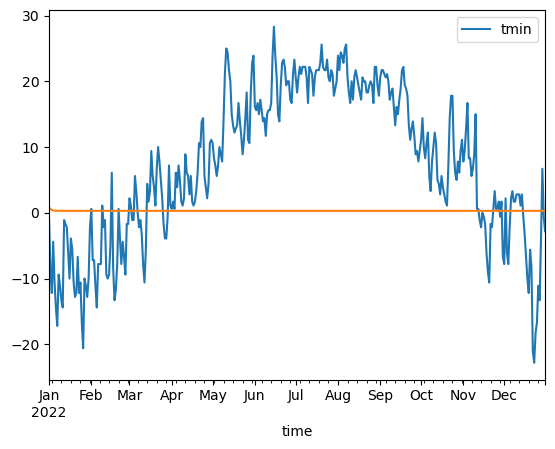

In [201]:
df_test.plot(y="tmin")
pred.plot()

In [194]:
from statsmodels.tsa.stattools import adfuller


def adf_test(series, title=""):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f"Augmented Dickey-Fuller Test: {title}")
    result = adfuller(
        series.dropna(), autolag="AIC"
    )  # .dropna() handles differenced data

    labels = ["ADF test statistic", "p-value", "# lags used", "# observations"]
    out = pd.Series(result[0:4], index=labels)

    for key, val in result[4].items():
        out[f"critical value ({key})"] = val

    print(out.to_string())  # .to_string() removes the line "dtype: float64"

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [170]:
adf_test(df["tmin"])

Augmented Dickey-Fuller Test: 
ADF test statistic     -9.466736e+00
p-value                 4.210403e-16
# lags used             4.300000e+01
# observations          1.529700e+04
critical value (1%)    -3.430778e+00
critical value (5%)    -2.861729e+00
critical value (10%)   -2.566871e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [172]:
pred.mean()

4.098775944572311

In [174]:
df["tmin"].mean()

6.43315950720292

In [175]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [190]:
r = seasonal_decompose(
    df["tmin"], model="add", extrapolate_trend="freq", period=365
)

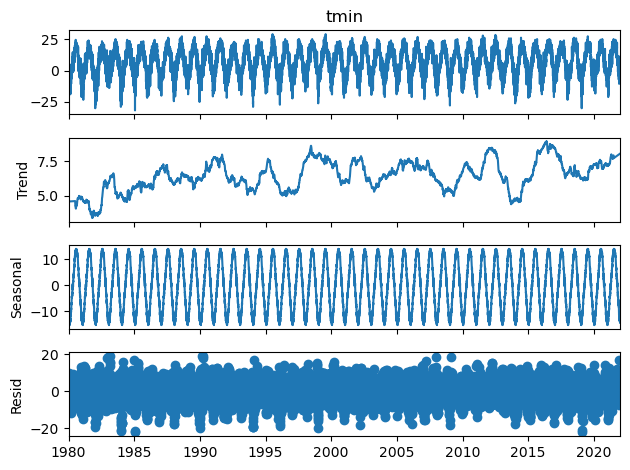

In [191]:
r.plot();